# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

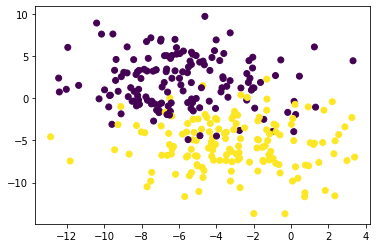

In [13]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# x, y = make_moons(n_samples=100, noise=0.1)
x, y = make_blobs(n_samples=300, cluster_std=3, centers=2)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими объектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [14]:
class Tree:
    def __init__(self, depth=1, max_num_leaf=1):
        self.struct = {}
        self.depth = depth
        self.max_num_leaf = max_num_leaf
   
    def get_criterion(self, attr: np.array, y: np.array) -> np.array:
        criterion = []
        for elem in np.sort(attr):
            left = y[attr <= elem]
            right = y[attr > elem]
            if len(right):
        #       Классы ,которые хранятся в y
                classes = np.unique(y)
                sum_prob_left, sum_prob_right = 0, 0
                for cl in classes:
                    prob_left = len(left[left == cl]) / len(left)
                    prob_right = len(right[right == cl]) / len(right)
                    sum_prob_left += prob_left * (1 - prob_left)
                    sum_prob_right += prob_right * (1 - prob_right)
                criterion.append([elem, len(left)  / len(attr) * sum_prob_left +
                                        len(right) / len(attr) * sum_prob_right])
        criterion = np.array(criterion)
        min_crit = min(criterion[:, 1])
        index = criterion==min_crit
        split_elem = criterion[index[:,1]][0]
        index_min = criterion[:,0].searchsorted(split_elem[0])
        return (criterion[index_min, 0] + criterion[index_min-1, 0]) / 2, split_elem[1]
   
    
    def to_terminal(self, y):
        return y[y == 1].shape[0] / y.shape[0]

    def get_split(self, level, x, y):
        node = {}
    #                         i               t         yl       yr
        keys = ['level', 'attr_number', 'split_elem', 'left', 'right']
        crit =[]
        for index_col in range(x.shape[1]):
            crit.append([index_col, *self.get_criterion(x[:, index_col], y)])
        crit = np.array(crit)
        min_crit = min(crit[:, 2])
        index = crit==min_crit
        split = crit[index[:,2]][0]
        attr_number = int(split[0])
        split_t = split[1]

        x_left = x[x[:, attr_number] <= split_t]
        left = y[x[:, attr_number] <= split_t]
        x_right = x[x[:, attr_number] > split_t]
        right = y[x[:, attr_number] > split_t]
        node.update(zip(keys, [level, attr_number, split_t, (x_left, left), (x_right, right)]))
        return node
    
    def split(self, node):
        x_left, left = node['left']
        x_right, right = node['right']
        level = node['level'] + 1
        # check for a no split
        if not len(left) or not len(right):
            node['left'] = node['right'] = self.to_terminal(left + right)
            return
        # check for max depth
        if self.depth is not None and level >= self.depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        # process left child
        if len(left) <= self.max_num_leaf:
            node['left'] = self.to_terminal(left)
        else:

            node['left'] = self.get_split(level, x_left, left)
            self.split(node['left'])
        # process right child
        if len(right) <= self.max_num_leaf:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(level, x_right, right)
            self.split(node['right'])
    
    
    def train(self, x, y):
        self.struct = self.get_split(0, x, y)
        self.split(self.struct)

    def predict_elem(self, node, x_row):
        x_index = node['attr_number']
        split_elem = node['split_elem']
        if x_row[x_index] < split_elem:
            if isinstance(node['left'], dict):
                return self.predict_elem(node['left'], x_row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_elem(node['right'], x_row)
            else:
                return node['right']            

    def predict(self, x):
        return np.array(list(map(lambda x_row: self.predict_elem(self.struct, x_row), x)))

In [15]:
x_test = np.array([
    [ 0.13765868, -0.2008977 ],
    [-0.95971851,  0.27796568],
    [-0.99316517,  0.46012326],
    [ 0.16376018,  0.23321764],
    [-0.24502772,  0.96022326],
])

In [16]:
tr = Tree(depth=5)
tr.train(x, y)
tr.struct

{'level': 0,
 'attr_number': 1,
 'split_elem': -2.0163051859270715,
 'left': {'level': 1,
  'attr_number': 1,
  'split_elem': -4.941737627257849,
  'left': {'level': 2,
   'attr_number': 0,
   'split_elem': -4.412211096261441,
   'left': {'level': 3,
    'attr_number': 0,
    'split_elem': -8.24069189700729,
    'left': {'level': 4,
     'attr_number': 0,
     'split_elem': -10.63415711067924,
     'left': 1.0,
     'right': 1.0},
    'right': {'level': 4,
     'attr_number': 0,
     'split_elem': -6.18148905176563,
     'left': 1.0,
     'right': 1.0}},
   'right': {'level': 3,
    'attr_number': 0,
    'split_elem': -0.6412295976317091,
    'left': {'level': 4,
     'attr_number': 0,
     'split_elem': -2.5479581137155445,
     'left': 1.0,
     'right': 1.0},
    'right': {'level': 4,
     'attr_number': 0,
     'split_elem': 1.2082048343968772,
     'left': 1.0,
     'right': 1.0}}},
  'right': {'level': 2,
   'attr_number': 1,
   'split_elem': -4.460302856378304,
   'left': {'leve

In [17]:
tr.predict(x_test)

array([0.54545455, 0.25      , 0.25      , 0.25      , 0.25      ])

In [18]:
y[:3], y[-4:-2]

(array([0, 1, 1]), array([0, 0]))

Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

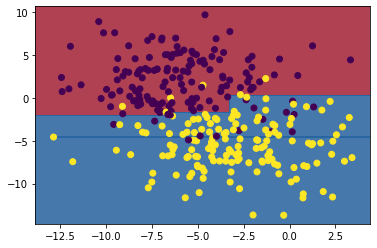

In [19]:
def tree_clf(x):
    y_pred = list()
    
    for it in x.transpose():
        pred_elem = tr.predict_elem(tr.struct, it)
        if pred_elem > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


Постройте дерево максимальной глубины для своих случайных данных.

In [21]:
tr = Tree(depth=None)
tr.train(x, y)
tr.struct

{'level': 0,
 'attr_number': 1,
 'split_elem': -2.0163051859270715,
 'left': {'level': 1,
  'attr_number': 1,
  'split_elem': -4.941737627257849,
  'left': {'level': 2,
   'attr_number': 0,
   'split_elem': -4.412211096261441,
   'left': {'level': 3,
    'attr_number': 0,
    'split_elem': -8.24069189700729,
    'left': {'level': 4,
     'attr_number': 0,
     'split_elem': -10.63415711067924,
     'left': 1.0,
     'right': {'level': 5,
      'attr_number': 0,
      'split_elem': -9.445794052672642,
      'left': 1.0,
      'right': 1.0}},
    'right': {'level': 4,
     'attr_number': 0,
     'split_elem': -6.18148905176563,
     'left': {'level': 5,
      'attr_number': 0,
      'split_elem': -7.033090900970999,
      'left': {'level': 6,
       'attr_number': 0,
       'split_elem': -7.605905354992588,
       'left': 1.0,
       'right': {'level': 7,
        'attr_number': 0,
        'split_elem': -7.507696231782658,
        'left': 1.0,
        'right': 1.0}},
      'right': {'leve

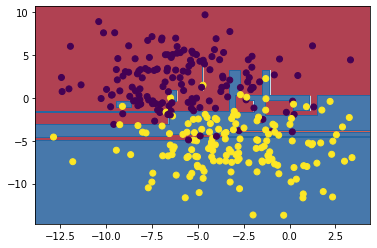

In [22]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)
